In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
import tensorflow as tf
print(tf.__version__)


2.4.0


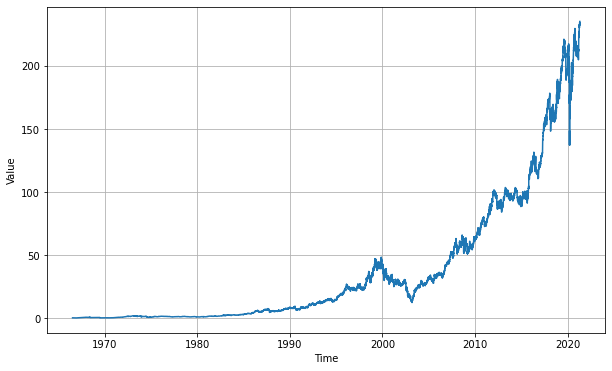

In [4]:
import csv
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def plot_series_all(time, data, title='Bitcoin price', xlabel='year', ylabel='price'):
    plt.plot(time, data)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.show()

def read_data(filepath='../data/MCD-USD.csv'):
    DATE_FORMAT = "%Y-%m-%d"
    time_step = []
    prices = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skip header
        for row in reader:
            if row[4] != 'null':
                time_step.append(datetime.strptime(row[0], DATE_FORMAT).date())
                prices.append(float(row[4]))
    return np.array(time_step), np.array(prices)




# time = np.arange(4 * 365 + 1, dtype="float32")
time, series = read_data()

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it so we can start forecasting

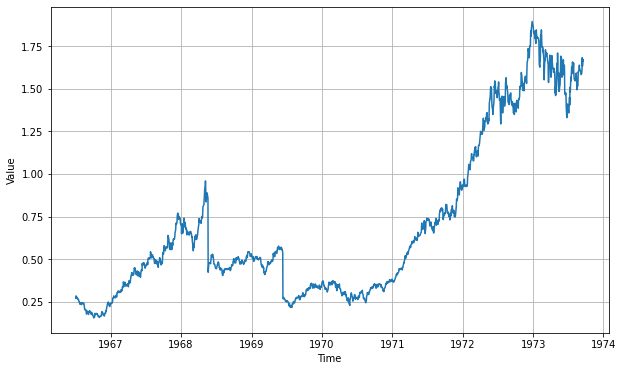

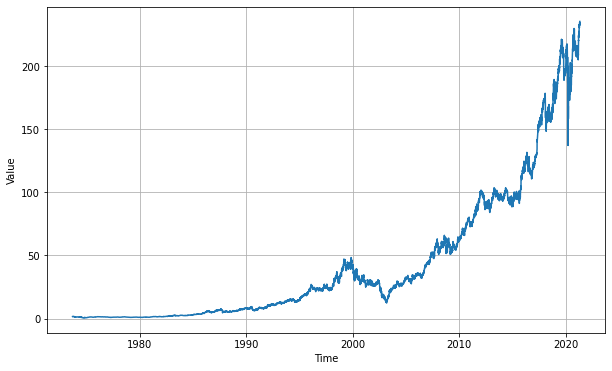

In [5]:
split_time = 1790
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [6]:
naive_forecast = series[split_time - 1:-1]

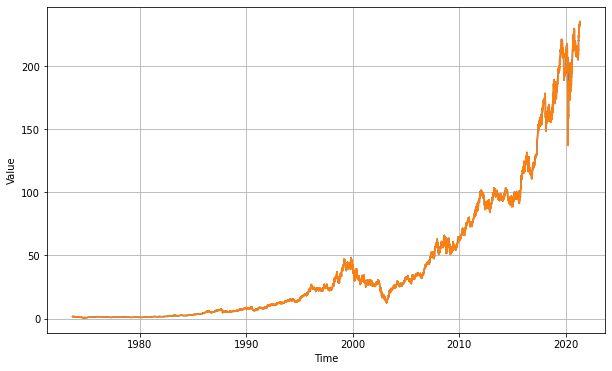

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

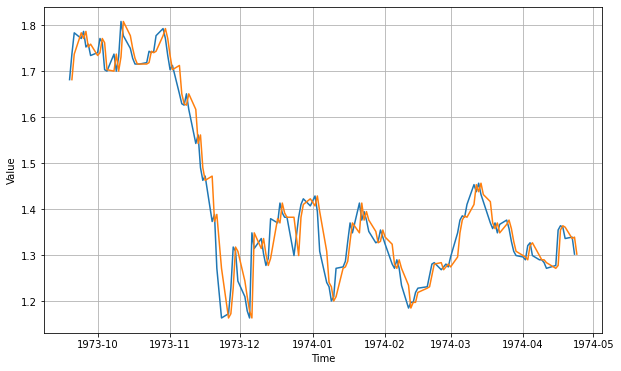

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [11]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

0.8959105505362732
0.40212726280289773


That's our baseline, now let's try a moving average:

In [12]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

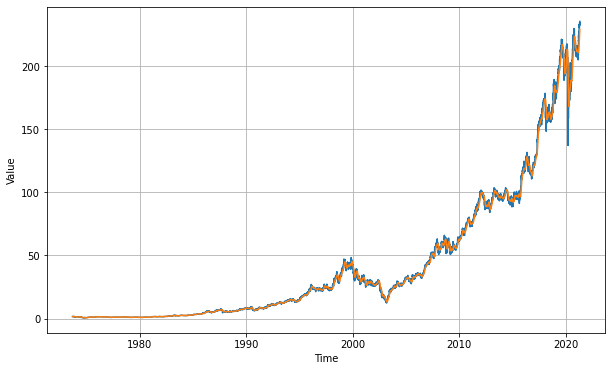

In [13]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)


Sneak peek into the future:

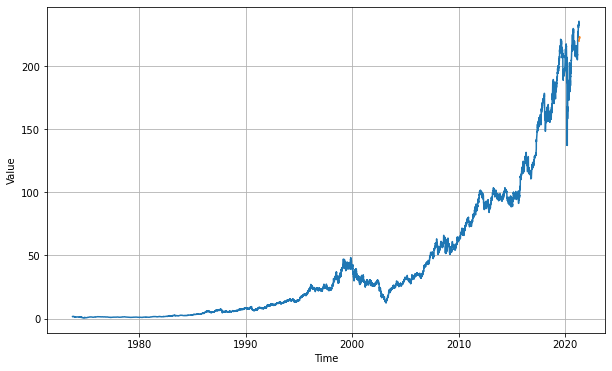

In [14]:
moving_avg_last_month = moving_avg[-30:]
moving_avg_future = np.copy(moving_avg_last_month)
last_known_date = time_valid[-1]
forecast_time = []
for time in range(len(moving_avg_future)):
    moving_avg_future = np.append(moving_avg_future, moving_avg_future[time:time + 30].mean())
    forecast_time.append(last_known_date + timedelta(days=time))

forecast_next_month = moving_avg_future[-30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(forecast_time, forecast_next_month)

In [15]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

7.519903547466051
1.2605749455491715


That's worse than naive forecast, *Deep learning to the rescue!

TODO: shortly describe what else can we do to improve it, like using differential data, remove noise or try different algorithms:
```
Method 1 – Start with a Naive Approach
Method 2 – Simple average
Method 3 – Moving average
Method 4 – Single Exponential smoothing
Method 5 – Holt’s linear trend method
Method 6 – Holt’s Winter seasonal method
Method 7 – ARIMA
```
https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/